In [26]:
%load_ext autoreload
%autoreload 2
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from utils.network import VarNet
import torch
from script.train_knee3d import *
from utils.cg_spirit_gpu import *
from utils.dataset import *
from scipy.linalg import null_space
import fastmri.data.transforms as T
from functools import partial
from utils.evaluation import esp

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
net = VarNet2()
net.load_state_dict(torch.load('exp/E2EVN_knee3D.pt'))
net = net.cuda()

In [124]:
R = 14
fname = 'data/div_knee3d/Test/18.h5'
testset = Subject3D(fname=fname, acc=R)

# SPIRIT refinement

In [125]:
ksp, mask, sens, labels = testset[200]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
sens = sens.unsqueeze(0).cuda()

with torch.no_grad():
    out, ksp_out = net(ksp, mask, sens)

In [126]:
mask_np = mask.cpu().detach().numpy()
print('Acceleration',1/mask_np.mean())

Acceleration 13.993850358729075


In [127]:
res_vn_spirit, ksp_vn_spirit = SS_refine(ksp, ksp_out, sens, algorithm='spirit', kernel_size=[5,5])

In [128]:
# Plotting resulting coil combined image
res_vn = from_pytorch(out.cpu().detach(), iscomplex=True)[0,0]
res_vn_rsc = res_vn_spirit
res_true = from_pytorch(labels.cpu().detach(), iscomplex=True)[0]

print(res_vn.shape, res_vn_rsc.shape, res_true.shape)

(256, 320) (256, 320) (256, 320)


In [129]:
import scipy.io as io
io.savemat('test.mat',{'vn':res_vn, 'vn_rsc':res_vn_rsc, 'full_res':res_true})

In [130]:
def cat_resize_image(im1,im2,im3,size=[256,256]):
    im1 = sp.resize(np.abs(im1.squeeze()),size)
    im2 = sp.resize(np.abs(im2.squeeze()),size)
    im3 = sp.resize(np.abs(im3.squeeze()),size)
    full_cat = np.concatenate((im1, im2, im3), axis=1)
    return full_cat

In [131]:
res_full = cat_resize_image(res_vn, res_vn_rsc, res_true, size=[256,256])
res_mag = cat_resize_image(res_vn, res_vn_rsc, res_true, size=[128,128])
true_mag = cat_resize_image(res_true, res_true, res_true, size=[128,128])
err_mag = np.abs(res_mag - true_mag) * 5

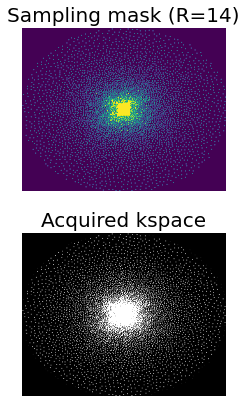

In [132]:
ksp_np = np.abs(from_pytorch(ksp.cpu().detach(), iscomplex=True)[0,0]) ** 0.2

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
ax1.imshow(mask_np.squeeze())
ax1.axis('off')
title_name = 'Sampling mask (R={})'.format(R)
ax1.set_title(title_name, {'fontsize':20})
ax2.imshow(ksp_np.squeeze(), cmap='gray', vmax=1)
ax2.axis('off')
ax2.set_title('Acquired kspace', {'fontsize':20})

fig.tight_layout()

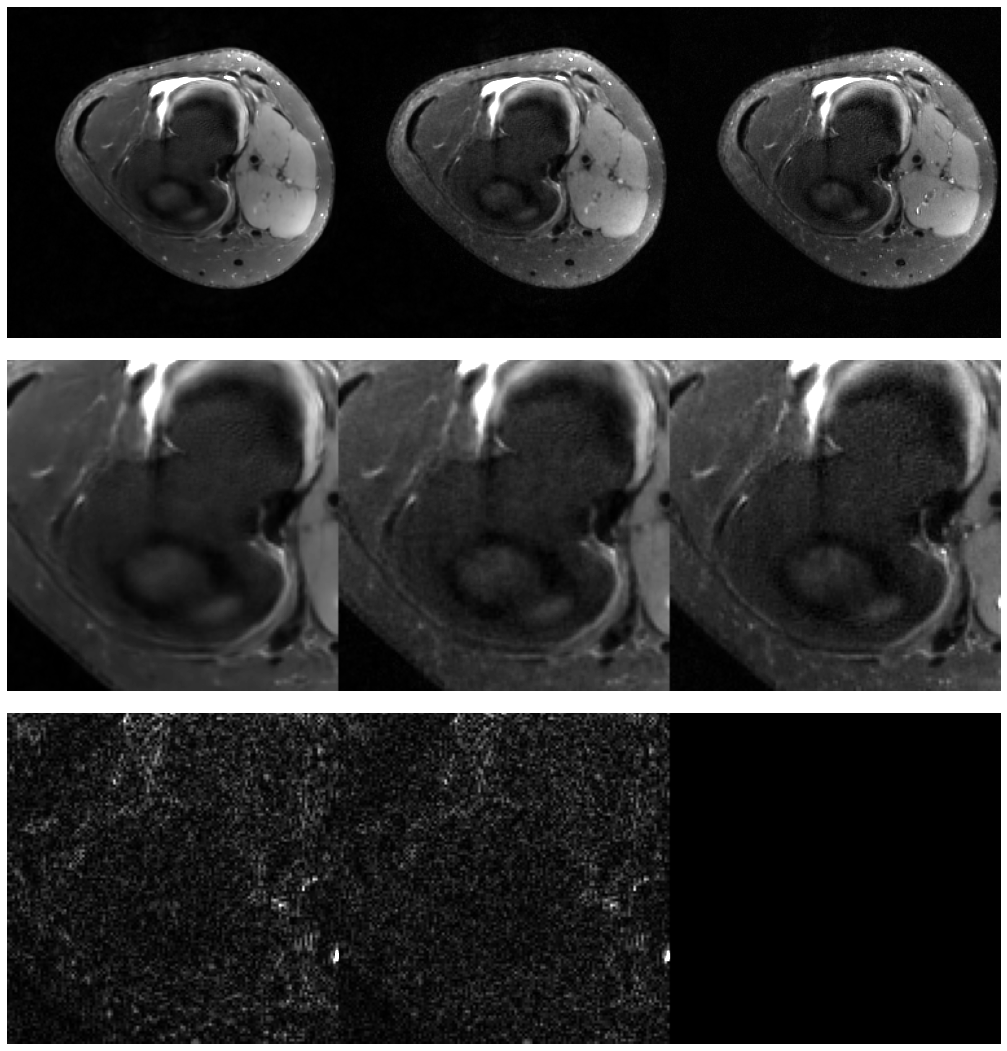

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.imshow(res_full,cmap='gray',vmax=500)
ax1.axis('off')

ax2.imshow(res_mag,cmap='gray',vmax=500)
ax2.axis('off')

ax3.imshow(err_mag,cmap='gray',vmax=500)
ax3.axis('off')

fig.tight_layout()


/home/gridsan/chanyeol/Kanghyun/VN_SPIRIT/VN_SPIRIT/utils/evaluation.py:57: RuntimeWarning: invalid value encountered in sqrt
  err_fraction = np.real(np.sqrt(err_plot/true_plot))


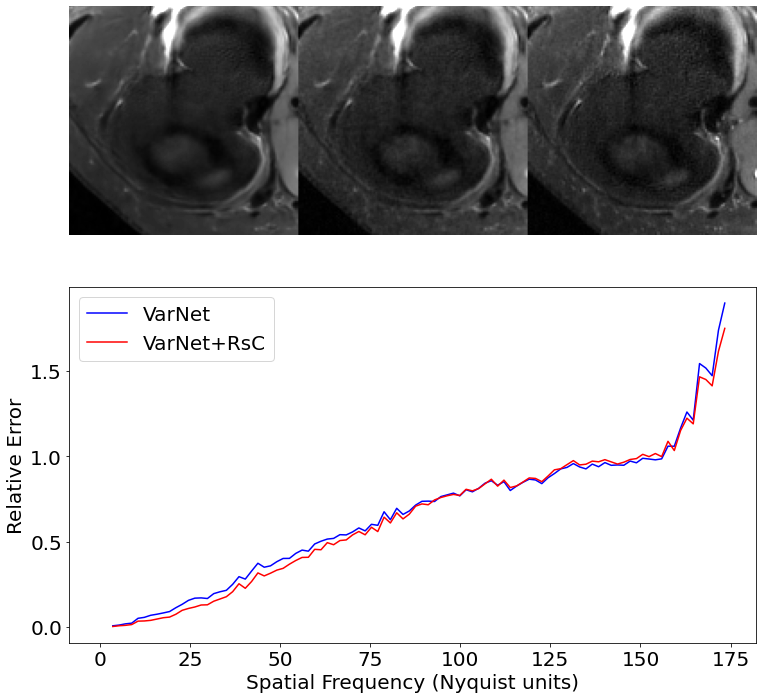

In [134]:
xi, esp_vn = esp(res_vn, res_true,0.999)
xi, esp_vn_spirit = esp(res_vn_rsc, res_true,0.999)

plt.rcParams['font.size'] = '20'

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11,11))

ax1.imshow(res_mag,cmap='gray',vmax=500)
ax1.axis('off')

ax2.plot(xi,esp_vn,'b',xi,esp_vn_spirit,'r')
ax2.legend(['VarNet','VarNet+RsC'])
plt.ylabel('Relative Error')
plt.xlabel('Spatial Frequency (Nyquist units)')
fig.tight_layout()

# Stacking subjects

In [135]:
with h5py.File(fname, 'r') as hf:
    kspace_full = hf['kspace'][:] * 1e-3

In [136]:
def proc_single_subj(testset, l2lam=0.03):
    vn_stack = []
    vn_rsc_stack = []
    true_stack = []
    for sl in tqdm(range(len(testset))):
        ksp, mask, sens, labels = testset[sl]
        ksp = ksp.unsqueeze(0).cuda()
        mask = mask.unsqueeze(0).cuda()
        sens = sens.unsqueeze(0).cuda()

        with torch.no_grad():
            out, ksp_out = net(ksp, mask, sens)

        res_vn_spirit, ksp_vn_spirit = SS_refine(ksp, ksp_out, sens, algorithm='spirit', l2lam=l2lam, kernel_size=[5,5])

        ksp_vn = from_pytorch(ksp_out.cpu().detach(), iscomplex=True)[0]
        ksp_vn_rsc = ksp_vn_spirit
        
        vn_stack.append(ksp_vn)
        vn_rsc_stack.append(ksp_vn_rsc)

    vn_stack = np.stack(vn_stack,0)
    vn_rsc_stack = np.stack(vn_rsc_stack,0)
    
    return vn_stack, vn_rsc_stack

def kspace_to_image(kspace):
    im_coil = sp.ifft(kspace,axes=(2,3))
    im_rss = sp.rss(im_coil,axes=1)
    return im_rss

def cat_resize_image(im1,im2,im3,size=[256,256]):
    im1 = sp.resize(np.abs(im1.squeeze()),size)
    im2 = sp.resize(np.abs(im2.squeeze()),size)
    im3 = sp.resize(np.abs(im3.squeeze()),size)
    full_cat = np.concatenate((im1, im2, im3), axis=1)
    return full_cat

In [137]:
vn, vn_rsc = proc_single_subj(testset)

100%|██████████| 320/320 [06:27<00:00,  1.21s/it]


In [138]:
vn_rss = kspace_to_image(vn)
vn_rsc_rss = kspace_to_image(vn_rsc)
true_rss = kspace_to_image(kspace_full)

In [148]:
sl = 128

res_full = cat_resize_image(vn_rss[:,sl], vn_rsc_rss[:,sl], true_rss[:,sl], size=[280,280])
res_mag = cat_resize_image(vn_rss[:,sl], vn_rsc_rss[:,sl], true_rss[:,sl], size=[140,140])

true_mag = cat_resize_image(true_rss[:,sl], true_rss[:,sl], true_rss[:,sl], size=[140,140])
err_mag = np.abs(res_mag - true_mag)


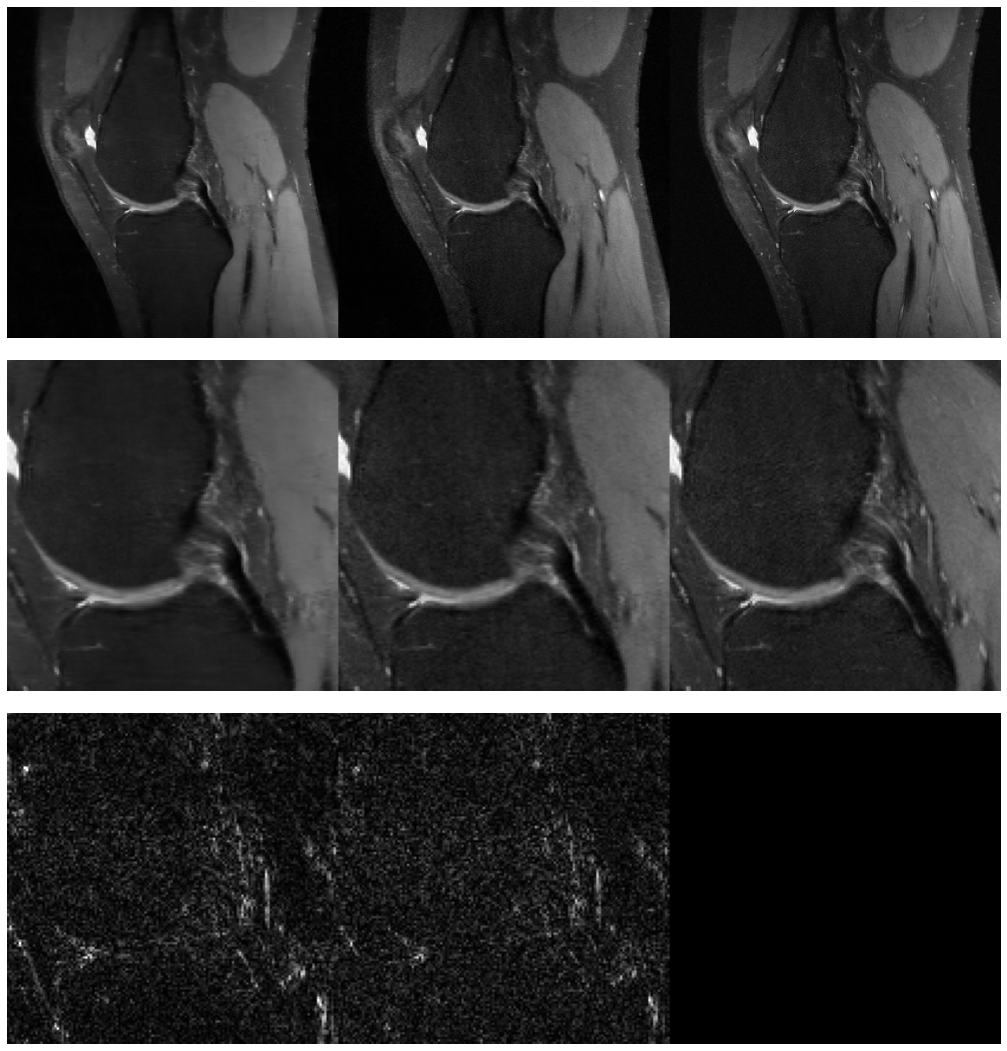

In [149]:
# Sagittal
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.imshow(res_full,cmap='gray',vmax=500)
ax1.axis('off')

ax2.imshow(res_mag,cmap='gray',vmax=500)
ax2.axis('off')

ax3.imshow(err_mag,cmap='gray',vmax=100)
ax3.axis('off')

fig.tight_layout()


/home/gridsan/chanyeol/Kanghyun/VN_SPIRIT/VN_SPIRIT/utils/evaluation.py:57: RuntimeWarning: invalid value encountered in sqrt
  err_fraction = np.real(np.sqrt(err_plot/true_plot))


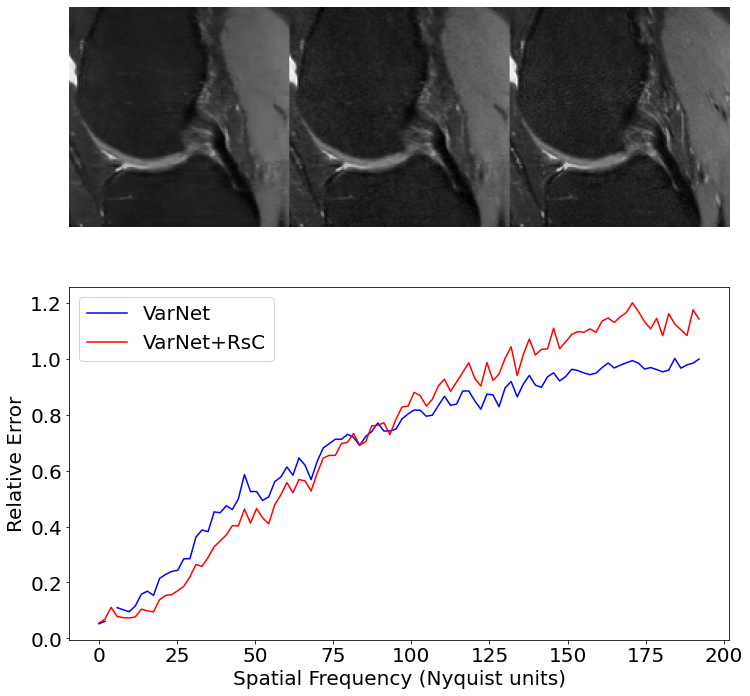

In [150]:
res_vn = vn_rss[:,sl]
res_vn_rsc = vn_rsc_rss[:,sl]
res_true = true_rss[:,sl]
xi, esp_vn = esp(res_vn, res_true,0.999)
xi, esp_vn_spirit = esp(res_vn_rsc, res_true,0.999)

plt.rcParams['font.size'] = '20'

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11,11))

ax1.imshow(res_mag,cmap='gray',vmax=500)
ax1.axis('off')

ax2.plot(xi,esp_vn,'b',xi,esp_vn_spirit,'r')
ax2.legend(['VarNet','VarNet+RsC'])
plt.ylabel('Relative Error')
plt.xlabel('Spatial Frequency (Nyquist units)')
fig.tight_layout()

In [155]:
# Coronal
sl = 180

res_full = cat_resize_image(vn_rss[:,:,sl], vn_rsc_rss[:,:,sl], true_rss[:,:,sl], size=[280,280])
res_mag = cat_resize_image(vn_rss[:,:,sl], vn_rsc_rss[:,:,sl], true_rss[:,:,sl], size=[140,140])

true_mag = cat_resize_image(true_rss[:,:,sl], true_rss[:,:,sl], true_rss[:,:,sl], size=[140,140])
err_mag = np.abs(res_mag - true_mag)


In [156]:
res_vn = vn_rss[:,:,sl]
res_vn_rsc = vn_rsc_rss[:,:,sl]
res_true = true_rss[:,:,sl]

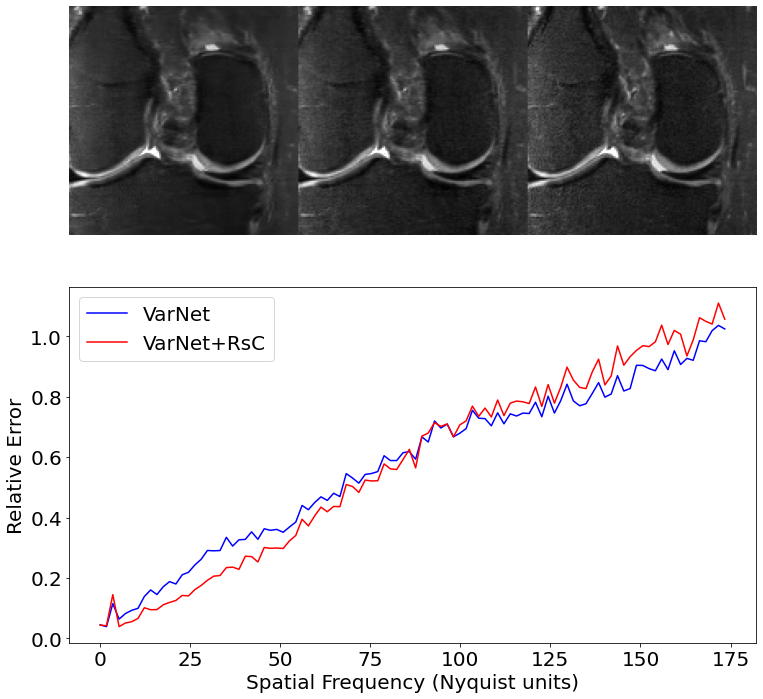

In [157]:
xi, esp_vn = esp(res_vn, res_true,0.999)
xi, esp_vn_spirit = esp(res_vn_rsc, res_true,0.999)

plt.rcParams['font.size'] = '20'

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11,11))

ax1.imshow(res_mag,cmap='gray',vmax=500)
ax1.axis('off')

ax2.plot(xi,esp_vn,'b',xi,esp_vn_spirit,'r')
ax2.legend(['VarNet','VarNet+RsC'])
plt.ylabel('Relative Error')
plt.xlabel('Spatial Frequency (Nyquist units)')
fig.tight_layout()

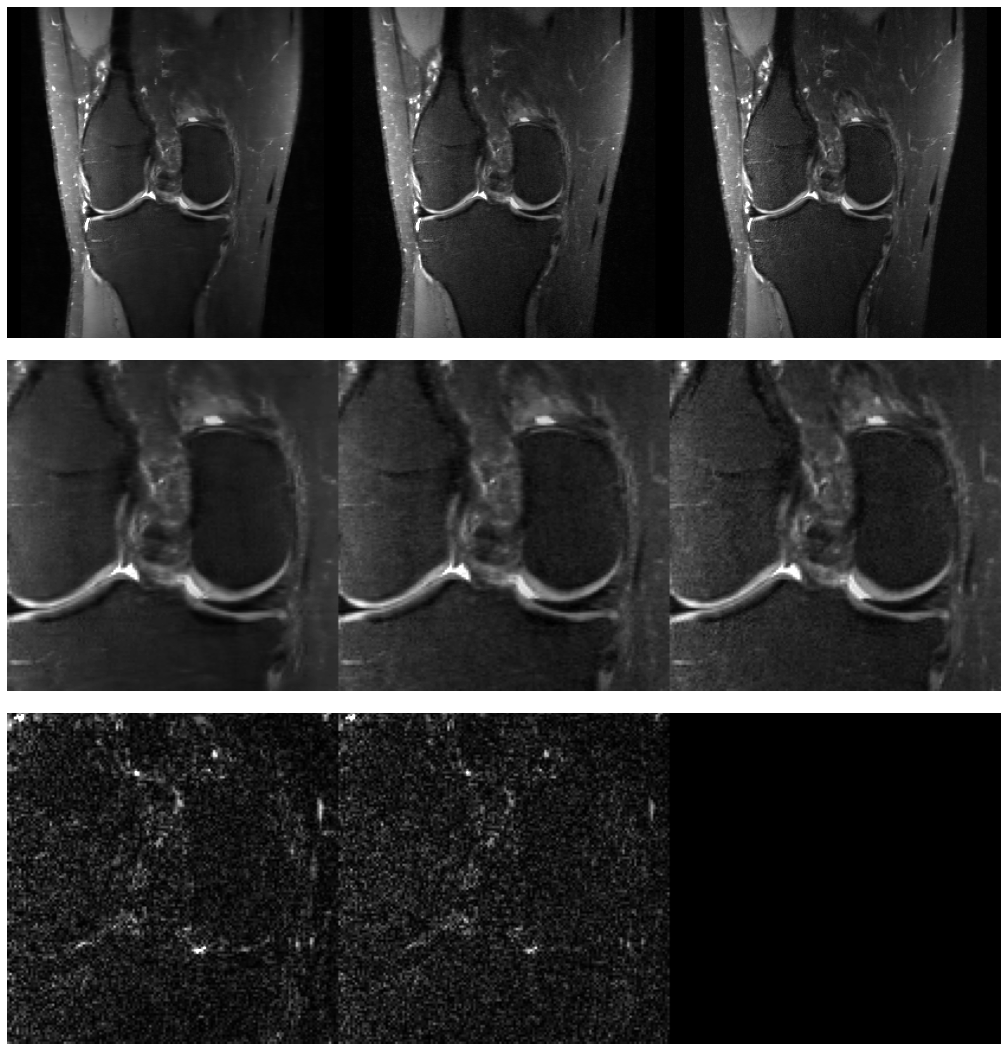

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.imshow(res_full,cmap='gray',vmax=500)
ax1.axis('off')

ax2.imshow(res_mag,cmap='gray',vmax=500)
ax2.axis('off')

ax3.imshow(err_mag,cmap='gray',vmax=100)
ax3.axis('off')

fig.tight_layout()
